# Opioid Addiction Project
## Notebook 05: Feature Importance

This notebook focuses on calculating feature importance

1. Load trained models from disk
2. Generate feature importance (Shapley values) ...
  * For the overall model
  * For individual predictions, including re-aggregating one-hot encoded values.

Generating feature importance (Shapley values) was originally also part of this notebook, but the long  execution time of model training and calibration made it more efficient to include in a new notebook.

### W210, Capstone
Summer 2019

Team:  Cameron Kennedy, Aditi Khullar, Rachel Kramer, Sharad Varadarajan

# 0. Load Libraries and Set Global Variables
This analysis is performed in the cells below.

In [1]:
#Import Required Libraries

#General libraries
import numpy as np
import pandas as pd
import joblib  #Used to save (pickle) models
from collections import defaultdict
import operator
import matplotlib.pyplot as plt
from scipy import stats

#Feature Importance
import shap #conda install -c conda-forge shap
shap.initjs()  #Javascript for Shapley Values

#Debugging / performance
from timeit import default_timer as timer

#Set initial parameter(s)
pd.set_option('display.max_rows', 100)
pd.options.display.max_columns = 200
dataDir = './data/'

# 1. Load Data

This step loads the models and data.

In [2]:
start = timer()

#Load Models
modelLR = joblib.load(dataDir+'modelLR.model')
calibratorLR = joblib.load(dataDir+'calibLR.model')

modelXGB = joblib.load(dataDir+'modelXGB.model')
calibratorXGB = joblib.load(dataDir+'calibXGB.model')


#Load data used for feature importance
#OLD, USING NUMPY NOW
#valX = pd.read_pickle(dataDir+'valX.pickle.zip')
#testX = pd.read_pickle(dataDir+'testX.pickle.zip')
valX = np.load(file=dataDir+'valX.npy')
testX = np.load(file=dataDir+'testX.npy')

#Load feature names (column names)
colNamesList = joblib.load(dataDir+'colNamesList.zip')

end = timer()
print('Run time: {:.1f} seconds'.format(end - start)) # Time in seconds

print(type(modelXGB))
print(type(calibratorXGB))
print(type(valX))
print(type(testX))

Run time: 0.1 seconds
<class 'xgboost.sklearn.XGBClassifier'>
<class 'sklearn.calibration.CalibratedClassifierCV'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


In [3]:
#Get stats (percentiles and such) for LR Cal
predProbsLRCal = calibratorLR.predict_proba(testX)[:,1]
print('LR CALIBRATED')
print('33%, 50% (median), 67% quantiles:', np.quantile(predProbsLRCal, [1/3, 1/2, 2/3]))
print('Average Score:', np.mean(predProbsLRCal))
print('Percentile of Average Score:',stats.percentileofscore(predProbsLRCal, np.mean(predProbsLRCal)) / 100)

#Get stats (percentiles and such) for XGB Cal
predProbsXGBCal = calibratorXGB.predict_proba(testX)[:,1]
print('\nXGB CALIBRATED')
print('33%, 50% (median), 67% quantiles:', np.quantile(predProbsXGBCal, [1/3, 1/2, 2/3]))
print('Average Score:', np.mean(predProbsXGBCal))
print('Percentile of Average Score:',stats.percentileofscore(predProbsXGBCal, np.mean(predProbsXGBCal)) / 100)

LR CALIBRATED
33%, 50% (median), 67% quantiles: [0.08089669 0.09734513 0.12015504]
Average Score: 0.16144952322018294
Percentile of Average Score: 0.6779110444777611

XGB CALIBRATED
33%, 50% (median), 67% quantiles: [0.08207089 0.10325896 0.14107017]
Average Score: 0.16028710000537175
Percentile of Average Score: 0.7267616191904048


# 2. Feature Importance

This section calculates feature importance for the models, split into two items:

1. Calculate overall feature importance for the model. This will be useful for understanding the model as a whole, and in that sense is akin to EDA, but for the model rather than the raw data.
2. Calculate feature importance for an individual example. This is what will be used when giving individual respondents their score.

As part of these tasks, we will also incorporate aggregating feature importance scores from one-hot encoded features.

In [4]:
calibratorXGB.predict_proba(np.array(testX[[6]]))[0][1]

0.06522475928068161

In [5]:
#Make a single prediction
for row in range(0,50):
    predLR = modelLR.predict_proba(testX[[row]])[0][1]
    predLRCal = calibratorLR.predict_proba(testX[[row]])[0][1]
    
    predXGB = modelXGB.predict_proba(testX[[row]])[0][1]
    predXGBCal = calibratorXGB.predict_proba(testX[[row]])[0][1]
    
    #print('Case {}:  UNCALIBRATED LR Prediction: {:.2%}'.format(row, predLR))
    print('Case {}:    CALIBRATED LR Prediction: {:.2%}'.format(row, predLRCal))
    #print('Case {}: UNCALIBRATED XGB Prediction: {:.2%}'.format(row, predXGB))
    print('Case {}:   CALIBRATED XGB Prediction: {:.2%}\n'.format(row, predXGBCal))       

Case 0:    CALIBRATED LR Prediction: 8.09%
Case 0:   CALIBRATED XGB Prediction: 9.56%

Case 1:    CALIBRATED LR Prediction: 3.71%
Case 1:   CALIBRATED XGB Prediction: 6.56%

Case 2:    CALIBRATED LR Prediction: 4.89%
Case 2:   CALIBRATED XGB Prediction: 6.30%

Case 3:    CALIBRATED LR Prediction: 12.02%
Case 3:   CALIBRATED XGB Prediction: 9.46%

Case 4:    CALIBRATED LR Prediction: 26.12%
Case 4:   CALIBRATED XGB Prediction: 9.64%

Case 5:    CALIBRATED LR Prediction: 4.89%
Case 5:   CALIBRATED XGB Prediction: 8.31%

Case 6:    CALIBRATED LR Prediction: 4.89%
Case 6:   CALIBRATED XGB Prediction: 6.52%

Case 7:    CALIBRATED LR Prediction: 25.99%
Case 7:   CALIBRATED XGB Prediction: 24.99%

Case 8:    CALIBRATED LR Prediction: 8.41%
Case 8:   CALIBRATED XGB Prediction: 14.75%

Case 9:    CALIBRATED LR Prediction: 9.09%
Case 9:   CALIBRATED XGB Prediction: 7.29%

Case 10:    CALIBRATED LR Prediction: 12.02%
Case 10:   CALIBRATED XGB Prediction: 9.96%

Case 11:    CALIBRATED LR Predictio

In [6]:
#Calculate Shapley Values
#NOTE: Currently this takes a couple minutes to run

#Create XGB Explainer
explainerXGB = shap.TreeExplainer(modelXGB, valX, feature_dependence='independent', model_output='probability')
#Note, very specifically this is where we need XGBoost 0.81 (0.80 failed, and 0.90 killed the kernel).


##### DON'T FORGET TO CHANGE kSize FOR FINAL MODEL!! #####

#Create LR Calibrated Explainer
kSize = 500 #Size of the cluster
'''With kSize = 200 it takes ~1.2 sec to generate a prediction.
Setting to 500 for production model to generate more robust predictions.
'''
valX_Kmeans = shap.kmeans(valX, kSize)
explainerLRCal = shap.KernelExplainer(calibratorLR.predict_proba, valX_Kmeans)

#OLD WAY (slow because it uses all the background samples, using kmeans instead, above)
#explainerLRCal = shap.KernelExplainer(calibratorLR.predict_proba, valX)

#This helped at one point: https://evgenypogorelov.com/multiclass-xgb-shap.html

#Create XGB Calibrated Explainer
explainerXGBCal = shap.KernelExplainer(calibratorXGB.predict_proba, valX_Kmeans)

'''WARNING MESSAGE:
Using 13340 background data samples could cause slower run times. 
Consider using shap.kmeans(data, K) to summarize the background as K weighted samples.
''';

Using 500 background data samples could cause slower run times. Consider using shap.kmeans(data, K) to summarize the background as K weighted samples.
Using 500 background data samples could cause slower run times. Consider using shap.kmeans(data, K) to summarize the background as K weighted samples.


In [7]:
#Save the explainer (for use in the web app)
joblib.dump(explainerXGB, dataDir+'modelXGB.explainer')
joblib.dump(explainerLRCal, dataDir+'modelLRCal.explainer')
joblib.dump(explainerXGBCal, dataDir+'modelXGBCal.explainer')

['./data/modelXGBCal.explainer']

In [8]:
#Generate shapley values from samples 
numSamples = 100
'''With numSamples = 100, and kSize = 200, this cell takes ~3 min to run.

100 is an acceptable value because it sufficiently shows the spread of values, which is
all we're trying to do. It doesn't affect the Shapley accuracy.
'''
valXSample = valX[np.random.choice(valX.shape[0], numSamples, replace=False), :]
shap_valuesXGB = explainerXGB.shap_values(valXSample)
shap_valuesLRCal = explainerLRCal.shap_values(valXSample)
shap_valuesXGBCal = explainerXGBCal.shap_values(valXSample)

  0%|                                                                                          | 0/100 [00:00<?, ?it/s]C:\Users\camke\Anaconda3\lib\site-packages\shap\explainers\kernel.py:535: UserWarning: l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
  "l1_reg=\"auto\" is deprecated and in the next version (v0.29) the behavior will change from a " \
C:\Users\camke\Anaconda3\lib\site-packages\shap\explainers\kernel.py:535: UserWarning: l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
  "l1_reg=\"auto\" is deprecated and in the next version (v0.29) the behavior will change from a " \
  1%|▊                                                                                 | 1/100 [00:02<04:40,  2.84s/it]C:\Users\camke\Anaconda3\lib\site-packages\shap\explainers\kernel.py:535: UserWarning: l1_reg="a

C:\Users\camke\Anaconda3\lib\site-packages\shap\explainers\kernel.py:535: UserWarning: l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
  "l1_reg=\"auto\" is deprecated and in the next version (v0.29) the behavior will change from a " \
 11%|████████▉                                                                        | 11/100 [00:31<04:23,  2.96s/it]C:\Users\camke\Anaconda3\lib\site-packages\shap\explainers\kernel.py:535: UserWarning: l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
  "l1_reg=\"auto\" is deprecated and in the next version (v0.29) the behavior will change from a " \
C:\Users\camke\Anaconda3\lib\site-packages\shap\explainers\kernel.py:535: UserWarning: l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "nu

 21%|█████████████████                                                                | 21/100 [01:00<03:44,  2.84s/it]C:\Users\camke\Anaconda3\lib\site-packages\shap\explainers\kernel.py:535: UserWarning: l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
  "l1_reg=\"auto\" is deprecated and in the next version (v0.29) the behavior will change from a " \
C:\Users\camke\Anaconda3\lib\site-packages\shap\explainers\kernel.py:535: UserWarning: l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
  "l1_reg=\"auto\" is deprecated and in the next version (v0.29) the behavior will change from a " \
 22%|█████████████████▊                                                               | 22/100 [01:03<03:42,  2.86s/it]C:\Users\camke\Anaconda3\lib\site-packages\shap\explainers\kernel.py:535: UserWarning: l1_reg="a

C:\Users\camke\Anaconda3\lib\site-packages\shap\explainers\kernel.py:535: UserWarning: l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
  "l1_reg=\"auto\" is deprecated and in the next version (v0.29) the behavior will change from a " \
 32%|█████████████████████████▉                                                       | 32/100 [01:31<03:11,  2.82s/it]C:\Users\camke\Anaconda3\lib\site-packages\shap\explainers\kernel.py:535: UserWarning: l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
  "l1_reg=\"auto\" is deprecated and in the next version (v0.29) the behavior will change from a " \
C:\Users\camke\Anaconda3\lib\site-packages\shap\explainers\kernel.py:535: UserWarning: l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "nu

 42%|██████████████████████████████████                                               | 42/100 [01:59<02:43,  2.82s/it]C:\Users\camke\Anaconda3\lib\site-packages\shap\explainers\kernel.py:535: UserWarning: l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
  "l1_reg=\"auto\" is deprecated and in the next version (v0.29) the behavior will change from a " \
C:\Users\camke\Anaconda3\lib\site-packages\shap\explainers\kernel.py:535: UserWarning: l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
  "l1_reg=\"auto\" is deprecated and in the next version (v0.29) the behavior will change from a " \
 43%|██████████████████████████████████▊                                              | 43/100 [02:02<02:40,  2.82s/it]C:\Users\camke\Anaconda3\lib\site-packages\shap\explainers\kernel.py:535: UserWarning: l1_reg="a

C:\Users\camke\Anaconda3\lib\site-packages\shap\explainers\kernel.py:535: UserWarning: l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
  "l1_reg=\"auto\" is deprecated and in the next version (v0.29) the behavior will change from a " \
 53%|██████████████████████████████████████████▉                                      | 53/100 [02:30<02:12,  2.83s/it]C:\Users\camke\Anaconda3\lib\site-packages\shap\explainers\kernel.py:535: UserWarning: l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
  "l1_reg=\"auto\" is deprecated and in the next version (v0.29) the behavior will change from a " \
C:\Users\camke\Anaconda3\lib\site-packages\shap\explainers\kernel.py:535: UserWarning: l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "nu

 63%|███████████████████████████████████████████████████                              | 63/100 [02:59<01:45,  2.85s/it]C:\Users\camke\Anaconda3\lib\site-packages\shap\explainers\kernel.py:535: UserWarning: l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
  "l1_reg=\"auto\" is deprecated and in the next version (v0.29) the behavior will change from a " \
C:\Users\camke\Anaconda3\lib\site-packages\shap\explainers\kernel.py:535: UserWarning: l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
  "l1_reg=\"auto\" is deprecated and in the next version (v0.29) the behavior will change from a " \
 64%|███████████████████████████████████████████████████▊                             | 64/100 [03:02<01:41,  2.83s/it]C:\Users\camke\Anaconda3\lib\site-packages\shap\explainers\kernel.py:535: UserWarning: l1_reg="a

C:\Users\camke\Anaconda3\lib\site-packages\shap\explainers\kernel.py:535: UserWarning: l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
  "l1_reg=\"auto\" is deprecated and in the next version (v0.29) the behavior will change from a " \
 74%|███████████████████████████████████████████████████████████▉                     | 74/100 [03:30<01:13,  2.84s/it]C:\Users\camke\Anaconda3\lib\site-packages\shap\explainers\kernel.py:535: UserWarning: l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
  "l1_reg=\"auto\" is deprecated and in the next version (v0.29) the behavior will change from a " \
C:\Users\camke\Anaconda3\lib\site-packages\shap\explainers\kernel.py:535: UserWarning: l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "nu

 84%|████████████████████████████████████████████████████████████████████             | 84/100 [03:58<00:46,  2.88s/it]C:\Users\camke\Anaconda3\lib\site-packages\shap\explainers\kernel.py:535: UserWarning: l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
  "l1_reg=\"auto\" is deprecated and in the next version (v0.29) the behavior will change from a " \
C:\Users\camke\Anaconda3\lib\site-packages\shap\explainers\kernel.py:535: UserWarning: l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
  "l1_reg=\"auto\" is deprecated and in the next version (v0.29) the behavior will change from a " \
 85%|████████████████████████████████████████████████████████████████████▊            | 85/100 [04:01<00:43,  2.88s/it]C:\Users\camke\Anaconda3\lib\site-packages\shap\explainers\kernel.py:535: UserWarning: l1_reg="a

C:\Users\camke\Anaconda3\lib\site-packages\shap\explainers\kernel.py:535: UserWarning: l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
  "l1_reg=\"auto\" is deprecated and in the next version (v0.29) the behavior will change from a " \
 95%|████████████████████████████████████████████████████████████████████████████▉    | 95/100 [04:30<00:14,  2.91s/it]C:\Users\camke\Anaconda3\lib\site-packages\shap\explainers\kernel.py:535: UserWarning: l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
  "l1_reg=\"auto\" is deprecated and in the next version (v0.29) the behavior will change from a " \
C:\Users\camke\Anaconda3\lib\site-packages\shap\explainers\kernel.py:535: UserWarning: l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "nu

  5%|████                                                                              | 5/100 [00:23<07:34,  4.79s/it]C:\Users\camke\Anaconda3\lib\site-packages\shap\explainers\kernel.py:535: UserWarning: l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
  "l1_reg=\"auto\" is deprecated and in the next version (v0.29) the behavior will change from a " \
C:\Users\camke\Anaconda3\lib\site-packages\shap\explainers\kernel.py:535: UserWarning: l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
  "l1_reg=\"auto\" is deprecated and in the next version (v0.29) the behavior will change from a " \
  6%|████▉                                                                             | 6/100 [00:28<07:23,  4.72s/it]C:\Users\camke\Anaconda3\lib\site-packages\shap\explainers\kernel.py:535: UserWarning: l1_reg="a

C:\Users\camke\Anaconda3\lib\site-packages\shap\explainers\kernel.py:535: UserWarning: l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
  "l1_reg=\"auto\" is deprecated and in the next version (v0.29) the behavior will change from a " \
 16%|████████████▉                                                                    | 16/100 [01:14<06:24,  4.57s/it]C:\Users\camke\Anaconda3\lib\site-packages\shap\explainers\kernel.py:535: UserWarning: l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
  "l1_reg=\"auto\" is deprecated and in the next version (v0.29) the behavior will change from a " \
C:\Users\camke\Anaconda3\lib\site-packages\shap\explainers\kernel.py:535: UserWarning: l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "nu

 26%|█████████████████████                                                            | 26/100 [02:00<05:44,  4.66s/it]C:\Users\camke\Anaconda3\lib\site-packages\shap\explainers\kernel.py:535: UserWarning: l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
  "l1_reg=\"auto\" is deprecated and in the next version (v0.29) the behavior will change from a " \
C:\Users\camke\Anaconda3\lib\site-packages\shap\explainers\kernel.py:535: UserWarning: l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
  "l1_reg=\"auto\" is deprecated and in the next version (v0.29) the behavior will change from a " \
 27%|█████████████████████▊                                                           | 27/100 [02:05<05:37,  4.63s/it]C:\Users\camke\Anaconda3\lib\site-packages\shap\explainers\kernel.py:535: UserWarning: l1_reg="a

C:\Users\camke\Anaconda3\lib\site-packages\shap\explainers\kernel.py:535: UserWarning: l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
  "l1_reg=\"auto\" is deprecated and in the next version (v0.29) the behavior will change from a " \
 37%|█████████████████████████████▉                                                   | 37/100 [02:51<04:53,  4.65s/it]C:\Users\camke\Anaconda3\lib\site-packages\shap\explainers\kernel.py:535: UserWarning: l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
  "l1_reg=\"auto\" is deprecated and in the next version (v0.29) the behavior will change from a " \
C:\Users\camke\Anaconda3\lib\site-packages\shap\explainers\kernel.py:535: UserWarning: l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "nu

 47%|██████████████████████████████████████                                           | 47/100 [03:37<04:00,  4.54s/it]C:\Users\camke\Anaconda3\lib\site-packages\shap\explainers\kernel.py:535: UserWarning: l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
  "l1_reg=\"auto\" is deprecated and in the next version (v0.29) the behavior will change from a " \
C:\Users\camke\Anaconda3\lib\site-packages\shap\explainers\kernel.py:535: UserWarning: l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
  "l1_reg=\"auto\" is deprecated and in the next version (v0.29) the behavior will change from a " \
 48%|██████████████████████████████████████▉                                          | 48/100 [03:41<03:58,  4.58s/it]C:\Users\camke\Anaconda3\lib\site-packages\shap\explainers\kernel.py:535: UserWarning: l1_reg="a

C:\Users\camke\Anaconda3\lib\site-packages\shap\explainers\kernel.py:535: UserWarning: l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
  "l1_reg=\"auto\" is deprecated and in the next version (v0.29) the behavior will change from a " \
 58%|██████████████████████████████████████████████▉                                  | 58/100 [04:27<03:09,  4.50s/it]C:\Users\camke\Anaconda3\lib\site-packages\shap\explainers\kernel.py:535: UserWarning: l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
  "l1_reg=\"auto\" is deprecated and in the next version (v0.29) the behavior will change from a " \
C:\Users\camke\Anaconda3\lib\site-packages\shap\explainers\kernel.py:535: UserWarning: l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "nu

 68%|███████████████████████████████████████████████████████                          | 68/100 [05:13<02:28,  4.64s/it]C:\Users\camke\Anaconda3\lib\site-packages\shap\explainers\kernel.py:535: UserWarning: l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
  "l1_reg=\"auto\" is deprecated and in the next version (v0.29) the behavior will change from a " \
C:\Users\camke\Anaconda3\lib\site-packages\shap\explainers\kernel.py:535: UserWarning: l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
  "l1_reg=\"auto\" is deprecated and in the next version (v0.29) the behavior will change from a " \
 69%|███████████████████████████████████████████████████████▉                         | 69/100 [05:18<02:23,  4.61s/it]C:\Users\camke\Anaconda3\lib\site-packages\shap\explainers\kernel.py:535: UserWarning: l1_reg="a

C:\Users\camke\Anaconda3\lib\site-packages\shap\explainers\kernel.py:535: UserWarning: l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
  "l1_reg=\"auto\" is deprecated and in the next version (v0.29) the behavior will change from a " \
 79%|███████████████████████████████████████████████████████████████▉                 | 79/100 [06:03<01:36,  4.60s/it]C:\Users\camke\Anaconda3\lib\site-packages\shap\explainers\kernel.py:535: UserWarning: l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
  "l1_reg=\"auto\" is deprecated and in the next version (v0.29) the behavior will change from a " \
C:\Users\camke\Anaconda3\lib\site-packages\shap\explainers\kernel.py:535: UserWarning: l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "nu

 89%|████████████████████████████████████████████████████████████████████████         | 89/100 [06:49<00:50,  4.61s/it]C:\Users\camke\Anaconda3\lib\site-packages\shap\explainers\kernel.py:535: UserWarning: l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
  "l1_reg=\"auto\" is deprecated and in the next version (v0.29) the behavior will change from a " \
C:\Users\camke\Anaconda3\lib\site-packages\shap\explainers\kernel.py:535: UserWarning: l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
  "l1_reg=\"auto\" is deprecated and in the next version (v0.29) the behavior will change from a " \
 90%|████████████████████████████████████████████████████████████████████████▉        | 90/100 [06:54<00:46,  4.62s/it]C:\Users\camke\Anaconda3\lib\site-packages\shap\explainers\kernel.py:535: UserWarning: l1_reg="a

C:\Users\camke\Anaconda3\lib\site-packages\shap\explainers\kernel.py:535: UserWarning: l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
  "l1_reg=\"auto\" is deprecated and in the next version (v0.29) the behavior will change from a " \
100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [07:40<00:00,  4.62s/it]


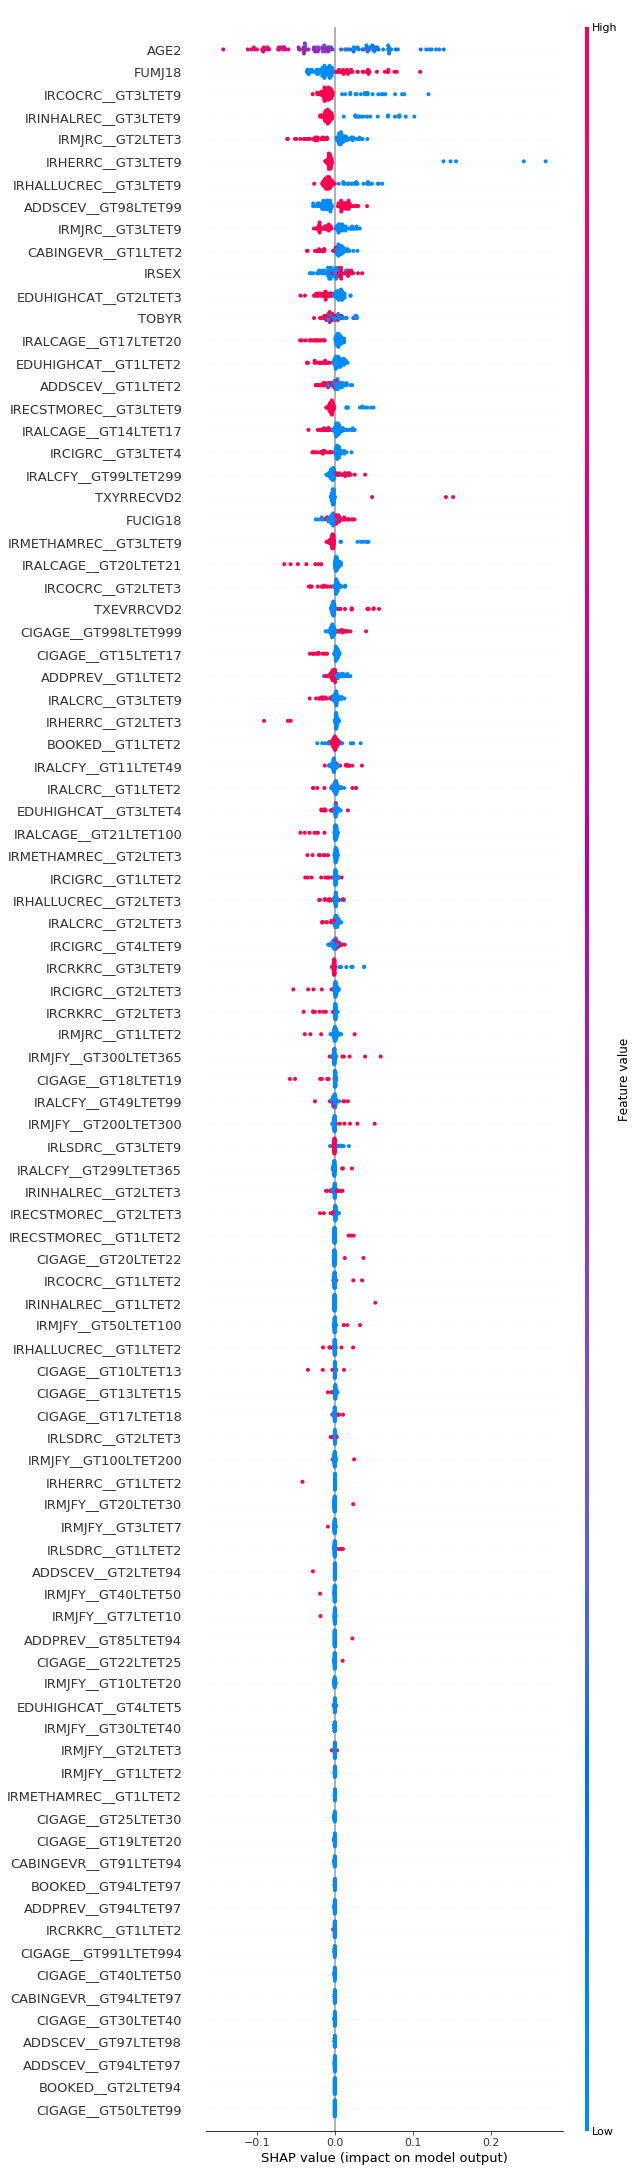

In [9]:
#Shapley Plot for XGB (uncalibrated)
shap.summary_plot(shap_valuesXGB, valXSample, 
                  feature_names=colNamesList, max_display=-1)

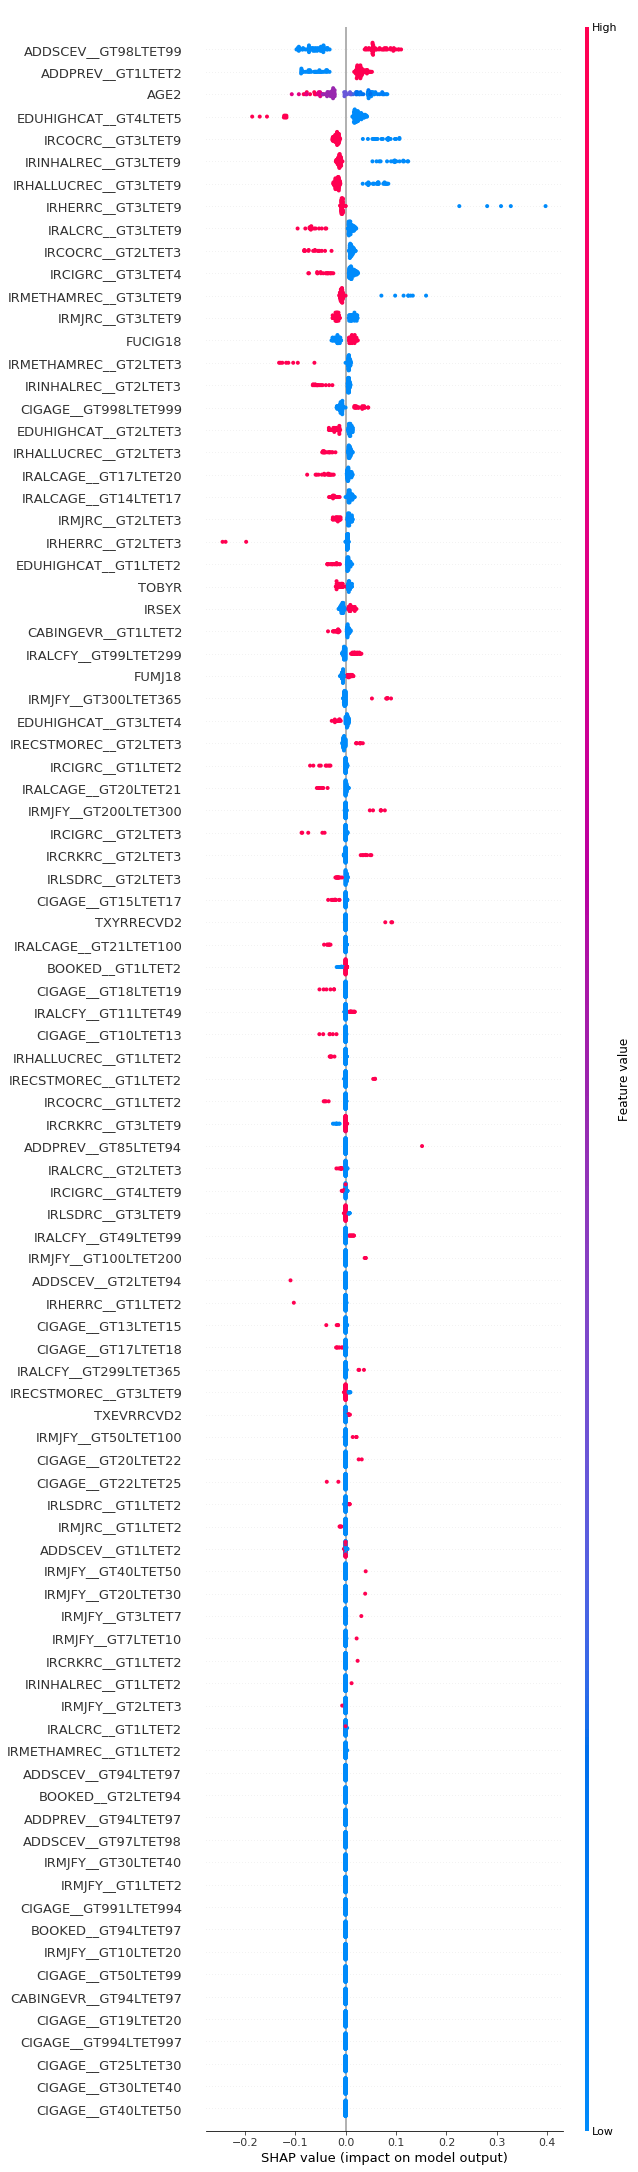

In [10]:
#Shapley Plot for Calibrated LR
shap.summary_plot(np.array(shap_valuesLRCal)[1], valXSample, 
                  feature_names=colNamesList, max_display=-1, auto_size_plot=True)

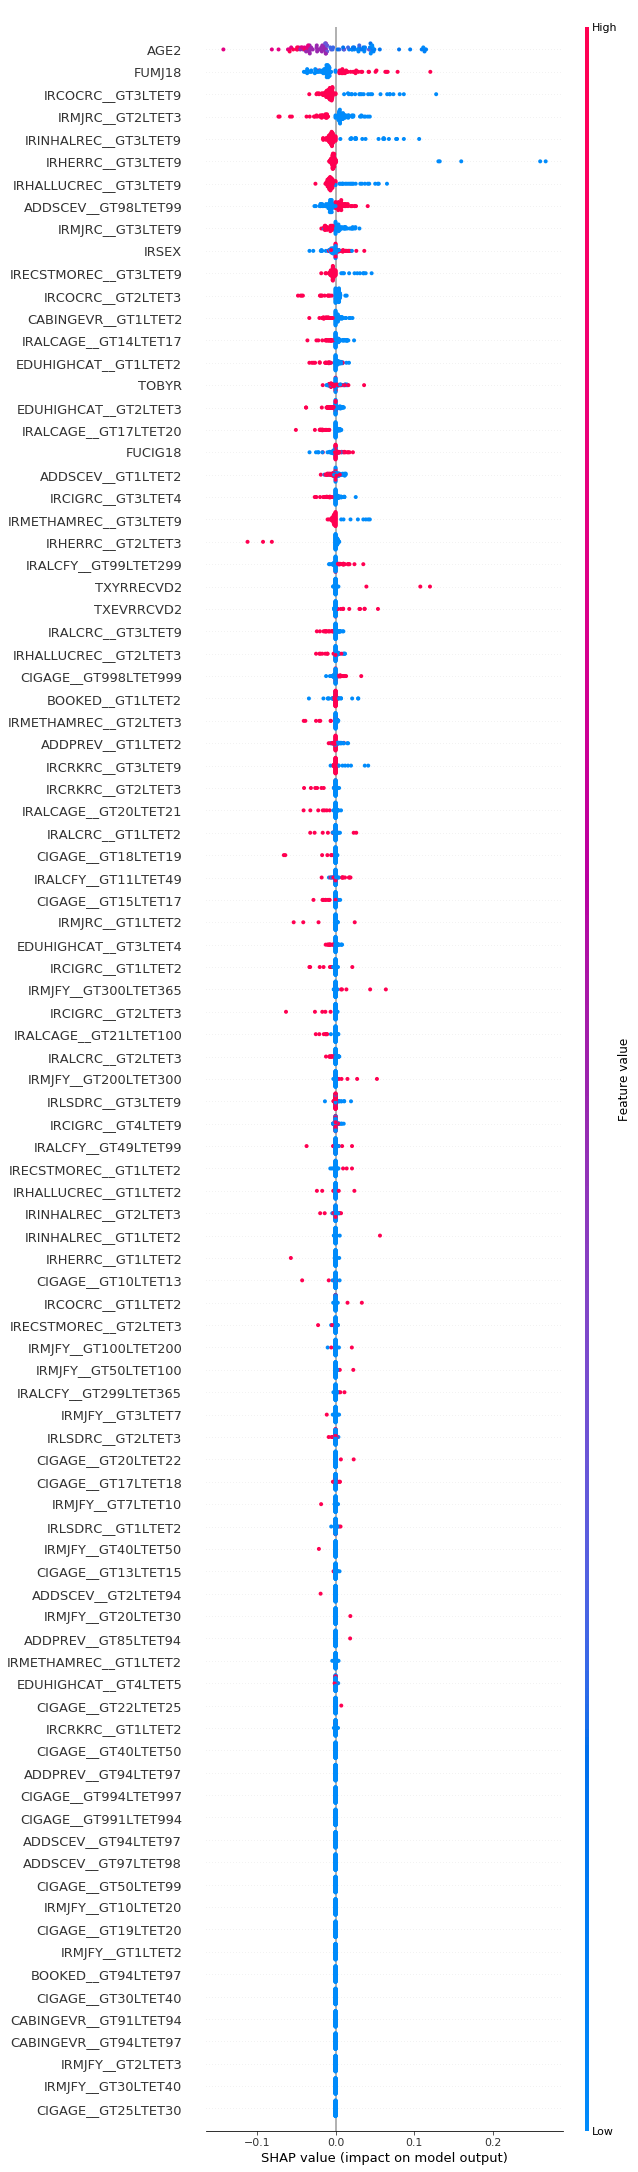

In [11]:
#Shapley Plot for Calibrated XGB
shap.summary_plot(np.array(shap_valuesXGBCal)[1], valXSample, 
                  feature_names=colNamesList, max_display=-1, auto_size_plot=True)

In [12]:
#print(shap_values) for XGB (uncalibrated)

np.set_printoptions(precision=3)
np.set_printoptions(suppress=True)

testCaseID = 14

print(shap_valuesXGB.shape)
print(shap_valuesXGB[testCaseID])

(100, 94)
[ 0.    -0.    -0.    -0.003  0.    -0.     0.     0.008 -0.092  0.001
  0.     0.     0.005 -0.     0.     0.     0.     0.002  0.     0.
 -0.    -0.    -0.    -0.     0.    -0.     0.    -0.     0.    -0.001
  0.002  0.005  0.001  0.    -0.002 -0.016  0.001  0.003  0.002  0.
 -0.001 -0.001 -0.    -0.002  0.002  0.003 -0.005  0.001  0.002  0.003
  0.006 -0.     0.003 -0.012 -0.     0.001 -0.001 -0.     0.    -0.004
 -0.     0.001 -0.007  0.     0.002 -0.005 -0.001  0.    -0.009 -0.
  0.    -0.     0.     0.001 -0.002 -0.     0.     0.     0.    -0.001
  0.    -0.001 -0.    -0.    -0.    -0.    -0.     0.001  0.006 -0.01
 -0.003  0.008 -0.003 -0.002]


In [13]:
#print(shap_values) for Calibrated LR

#Notice here how with the LRCal shapley values, we have to take the [1] to get the same
#as the XGB shapley values
print(np.array(shap_valuesLRCal)[1].shape)
print(np.array(shap_valuesLRCal)[1][testCaseID])

(100, 94)
[-0.038  0.     0.     0.     0.     0.     0.     0.043 -0.056  0.
  0.     0.     0.004  0.     0.     0.     0.     0.     0.     0.
  0.     0.     0.     0.     0.     0.     0.     0.     0.    -0.008
  0.004  0.007  0.003  0.019 -0.013 -0.005  0.006  0.004  0.     0.001
  0.     0.     0.    -0.002  0.     0.    -0.053  0.     0.     0.008
 -0.002  0.     0.009 -0.014  0.     0.     0.     0.    -0.003  0.
  0.     0.006 -0.014  0.     0.003 -0.006  0.     0.006 -0.01   0.
  0.002  0.     0.     0.006 -0.007  0.     0.     0.     0.     0.
  0.    -0.002  0.     0.     0.     0.     0.     0.     0.005 -0.016
 -0.005  0.007  0.     0.   ]


In [14]:
#print(shap_values) for Calibrated XGB
print(np.array(shap_valuesXGBCal)[1].shape)
print(np.array(shap_valuesXGBCal)[1][testCaseID])

(100, 94)
[ 0.     0.     0.    -0.001  0.     0.     0.     0.004 -0.056  0.
  0.     0.     0.002  0.     0.     0.     0.     0.     0.     0.
  0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
  0.001  0.002  0.     0.    -0.002 -0.016  0.002  0.001  0.     0.
  0.     0.     0.     0.     0.     0.    -0.004  0.     0.     0.002
  0.     0.     0.004 -0.009  0.     0.001  0.     0.     0.    -0.004
  0.     0.002 -0.005  0.     0.002 -0.004  0.     0.    -0.006  0.
  0.     0.     0.     0.002 -0.002  0.     0.     0.     0.     0.
  0.     0.     0.     0.     0.     0.     0.     0.     0.005 -0.006
 -0.002  0.003  0.     0.   ]


In [15]:
colNamesList.index('AGE2')

8

In [16]:
#A quick comparison of FUMJ18 and AGE2 for different models
locFUMJ18 = colNamesList.index('FUMJ18')
locAGE2 = colNamesList.index('AGE2')
print('locFUMJ18 Location:', locFUMJ18)
print('locAGE2 Location:', locAGE2)

for testCaseID in range(50,80):
    print('TEST CASE:', testCaseID)
    print('FUMJ18, XGB:    {:.1%}'.format(shap_valuesXGB[testCaseID][locFUMJ18]))
    print('FUMJ18, LRCal:  {:.1%}'.format(np.array(shap_valuesLRCal)[1][testCaseID][locFUMJ18]))
    print('FUMJ18, XGBCal: {:.1%}'.format(np.array(shap_valuesXGBCal)[1][testCaseID][locFUMJ18]))
    print()
    print('AGE2, XGB:    {:.1%}'.format(shap_valuesXGB[testCaseID][locAGE2]))
    print('AGE2, LRCal:  {:.1%}'.format(np.array(shap_valuesLRCal)[1][testCaseID][locAGE2]))
    print('AGE2, XGBCal: {:.1%}'.format(np.array(shap_valuesXGBCal)[1][testCaseID][locAGE2]))
    print()
    print()

locFUMJ18 Location: 35
locAGE2 Location: 8
TEST CASE: 50
FUMJ18, XGB:    -1.0%
FUMJ18, LRCal:  -0.5%
FUMJ18, XGBCal: -1.1%

AGE2, XGB:    -3.9%
AGE2, LRCal:  -2.8%
AGE2, XGBCal: -3.3%


TEST CASE: 51
FUMJ18, XGB:    -3.5%
FUMJ18, LRCal:  -0.7%
FUMJ18, XGBCal: -3.7%

AGE2, XGB:    6.9%
AGE2, LRCal:  5.2%
AGE2, XGBCal: 4.7%


TEST CASE: 52
FUMJ18, XGB:    0.6%
FUMJ18, LRCal:  0.7%
FUMJ18, XGBCal: 0.6%

AGE2, XGB:    -3.9%
AGE2, LRCal:  -3.7%
AGE2, XGBCal: -3.1%


TEST CASE: 53
FUMJ18, XGB:    -3.1%
FUMJ18, LRCal:  -0.6%
FUMJ18, XGBCal: -3.2%

AGE2, XGB:    2.5%
AGE2, LRCal:  4.5%
AGE2, XGBCal: 1.7%


TEST CASE: 54
FUMJ18, XGB:    2.9%
FUMJ18, LRCal:  0.8%
FUMJ18, XGBCal: 1.9%

AGE2, XGB:    4.5%
AGE2, LRCal:  5.9%
AGE2, XGBCal: 3.0%


TEST CASE: 55
FUMJ18, XGB:    -0.7%
FUMJ18, LRCal:  -0.7%
FUMJ18, XGBCal: -1.1%

AGE2, XGB:    -0.8%
AGE2, LRCal:  -3.5%
AGE2, XGBCal: -1.3%


TEST CASE: 56
FUMJ18, XGB:    -0.6%
FUMJ18, LRCal:  -0.7%
FUMJ18, XGBCal: -0.9%

AGE2, XGB:    -0.5%
AGE2, LRCal: 

## Individual Predictions

Now that we have our overall model, we can build predictions at the individual level.

It's important that from here forward, we generate a new shapley value for each individual prediction (don't use the values from the sample).

In [17]:
#Make an individual prediction on test data

#Get a random row from our test data
randTestRow = testX[np.random.choice(testX.shape[0], 1, replace=False), :] #1 means 1 row

#Make the prediction from the model(s)
predM = modelXGB.predict_proba(randTestRow)[0][1]
predC = calibratorXGB.predict_proba(randTestRow)[0][1]
print('UNCALIBRATED XGB Prediction: {:.1%}'.format(predM))
print('  CALIBRATED XGB Prediction: {:.1%}\n'.format(predC))

UNCALIBRATED XGB Prediction: 5.8%
  CALIBRATED XGB Prediction: 7.1%



In [18]:
randTestRow

array([[1.   , 0.   , 0.   , 1.   , 0.   , 0.   , 0.   , 0.   , 0.462,
        1.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   ,
        0.   , 1.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   ,
        0.   , 0.   , 0.   , 0.   , 1.   , 0.   , 0.   , 1.   , 0.   ,
        0.   , 0.   , 0.   , 0.   , 1.   , 0.   , 0.   , 0.   , 0.   ,
        0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 1.   ,
        0.   , 0.   , 1.   , 0.   , 0.   , 1.   , 0.   , 0.   , 1.   ,
        0.   , 0.   , 1.   , 0.   , 0.   , 1.   , 0.   , 0.   , 1.   ,
        0.   , 0.   , 1.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   ,
        0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 1.   ,
        1.   , 1.   , 0.   , 0.   ]])

In [19]:
start = timer()

#Generate shapley values from this row
shapVal = explainerLRCal.shap_values(randTestRow)

end = timer()
print('Run time: {:.0f} seconds'.format(end - start))

  0%|                                                                                            | 0/1 [00:00<?, ?it/s]C:\Users\camke\Anaconda3\lib\site-packages\shap\explainers\kernel.py:535: UserWarning: l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
  "l1_reg=\"auto\" is deprecated and in the next version (v0.29) the behavior will change from a " \
C:\Users\camke\Anaconda3\lib\site-packages\shap\explainers\kernel.py:535: UserWarning: l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
  "l1_reg=\"auto\" is deprecated and in the next version (v0.29) the behavior will change from a " \
100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.12s/it]


Run time: 3 seconds


In [20]:
#Plot shapley values
shap.force_plot(explainerLRCal.expected_value[1], shapVal[1], randTestRow, feature_names=colNamesList)

In the cell above, notice the prediction in the plot matches the uncalibrated prediction from the model.

In [21]:
#Get the baseline value (exepcted value)
expValLRCal = explainerLRCal.expected_value #This represents the AVERAGE (not the median) value
expValXGBCal = explainerXGBCal.expected_value #This represents the AVERAGE (not the median) value
print('Expected Value (Average), LR Calibrated {:.1%}'.format(expValLRCal[1]))
print('Expected Value (Average), XGB Calibrated {:.1%}'.format(expValXGBCal[1]))

Expected Value (Average), LR Calibrated 16.0%
Expected Value (Average), XGB Calibrated 16.5%


In [22]:
#Matrix of individual shapley values for each feature
np.array(shapVal[0])

array([[-0.028,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.061,
         0.028,  0.   ,  0.   ,  0.   , -0.004,  0.   ,  0.   ,  0.   ,
         0.   , -0.001,  0.   ,  0.027,  0.   ,  0.   ,  0.   ,  0.   ,
         0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.009, -0.005,  0.016,
        -0.003, -0.021, -0.01 ,  0.006, -0.008, -0.005, -0.002,  0.   ,
        -0.009,  0.   ,  0.   ,  0.003,  0.   ,  0.   , -0.008, -0.001,
         0.   , -0.01 ,  0.   ,  0.   , -0.011,  0.017,  0.   ,  0.002,
         0.   ,  0.   ,  0.003,  0.   ,  0.   , -0.008,  0.016,  0.   ,
        -0.003,  0.007,  0.   , -0.006,  0.012,  0.   ,  0.   ,  0.   ,
         0.   , -0.007,  0.008,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,
         0.   ,  0.002,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,
        -0.006,  0.018, -0.009,  0.007,  0.   ,  0.   ]])

In [23]:
explainerXGB.shap_values(randTestRow)

array([[-0.006, -0.   , -0.   , -0.008,  0.   , -0.   ,  0.   , -0.008,
        -0.028,  0.002,  0.   ,  0.   ,  0.006, -0.   ,  0.   , -0.   ,
         0.   ,  0.003,  0.   , -0.015, -0.   , -0.001, -0.   , -0.   ,
        -0.   , -0.   ,  0.   , -0.   ,  0.   , -0.005,  0.004, -0.013,
         0.001,  0.   ,  0.001, -0.014,  0.003,  0.003,  0.001,  0.001,
        -0.001, -0.001, -0.001, -0.003,  0.   ,  0.002,  0.001,  0.001,
         0.   ,  0.003, -0.001, -0.   ,  0.002, -0.007, -0.   ,  0.001,
        -0.001, -0.001,  0.001, -0.005, -0.   ,  0.001, -0.008,  0.   ,
         0.002, -0.006, -0.001, -0.   , -0.011, -0.   ,  0.   , -0.001,
         0.   ,  0.001, -0.002,  0.   , -0.   ,  0.   , -0.001, -0.   ,
         0.   , -0.   , -0.   , -0.   , -0.   , -0.   , -0.   ,  0.   ,
         0.006, -0.017,  0.005, -0.019, -0.001, -0.004]])

In [24]:
#Aggregate shapley values for one-hot vectors

shapDict = defaultdict(list) #Handy: creates blank list if key doesn't exist, or appends to it if it does.

#Get everything before the '_' character of each column name
#Then create the column index numbers for those keys 
#These numbers correspond to the locations in the shapley output array
for i, colName in enumerate(colNamesList):
    shapDict[colName.split('_')[0]].append(i)
    
#Make a list of aggregated values shapley
print(shapDict)
print()
for k in shapDict: #Loop through every key in the dict
    shapSum = 0.0 #Reset to 0
    for index in shapDict[k]: #Loop through every item in the key's value (a list of column indexes)
        shapSum += np.array(shapVal[0])[0][index] #Add the value for each item
    shapDict[k] = shapSum #Replace the list with the aggregated shapley value (the sum of each individual value)
    
print(shapDict)

defaultdict(<class 'list'>, {'ADDPREV': [0, 1, 2], 'ADDSCEV': [3, 4, 5, 6, 7], 'AGE2': [8], 'BOOKED': [9, 10, 11], 'CABINGEVR': [12, 13, 14], 'CIGAGE': [15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29], 'EDUHIGHCAT': [30, 31, 32, 33], 'FUCIG18': [34], 'FUMJ18': [35], 'IRALCAGE': [36, 37, 38, 39], 'IRALCFY': [40, 41, 42, 43], 'IRALCRC': [44, 45, 46], 'IRCIGRC': [47, 48, 49, 50], 'IRCOCRC': [51, 52, 53], 'IRCRKRC': [54, 55, 56], 'IRECSTMOREC': [57, 58, 59], 'IRHALLUCREC': [60, 61, 62], 'IRHERRC': [63, 64, 65], 'IRINHALREC': [66, 67, 68], 'IRLSDRC': [69, 70, 71], 'IRMETHAMREC': [72, 73, 74], 'IRMJFY': [75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86], 'IRMJRC': [87, 88, 89], 'IRSEX': [90], 'TOBYR': [91], 'TXEVRRCVD2': [92], 'TXYRRECVD2': [93]})

defaultdict(<class 'list'>, {'ADDPREV': -0.028286699253131903, 'ADDSCEV': 0.06097163759492136, 'AGE2': 0.02787050393668647, 'BOOKED': 0.0, 'CABINGEVR': -0.003527363659422973, 'CIGAGE': 0.03408011186079683, 'EDUHIGHCAT': -0.01332845583074

## Summary

So for output, we need:

1. User's prediction, __%
2. Percentile (later, need distribution first, not hard)
3. +/-__._% (just print for now)



In [25]:
#Print Summary Results
#Get a random row from our test data
randTestRow = testX[np.random.choice(testX.shape[0], 1, replace=False), :] #1 means 1 row

for model, explainer in [(calibratorLR, explainerLRCal), (calibratorXGB, explainerXGBCal)]:
    print()
    
    #Make the prediction from the model(s)
    predM = model.predict_proba(randTestRow)[0][1]
    print('Prediction: {:.1%}'.format(predM))

    #Generate shapley values from this row
    shapVal = explainer.shap_values(randTestRow)
    print('shapVal[1]:\n', shapVal[1])

    #Aggregate shapley values for one-hot vectors
    shapDict = defaultdict(list) #Handy: creates blank list if key doesn't exist, or appends to it if it does.

    #Get everything before the '_' character of each column name
    #Then create the column index numbers for those keys 
    #These numbers correspond to the locations in the shapley output array
    for i, colName in enumerate(colNamesList):
        shapDict[colName.split('_')[0]].append(i)

    #Make a list of aggregated shapley values
    for k in shapDict: #Loop through every key in the dict
        shapSum = 0.0 #Reset to 0
        for index in shapDict[k]: #Loop through every item in the key's value (a list of column indexes)
            shapSum += shapVal[1][0][index] #Add the value for each item
        shapDict[k] = shapSum #Replace the list with the aggregated shapley value (the sum of each individual value)

    sortedShapDict = dict(sorted(shapDict.items(), key=operator.itemgetter(1)))
    print('Feature Importance:')
    print(sortedShapDict)


Prediction: 8.4%


  0%|                                                                                            | 0/1 [00:00<?, ?it/s]C:\Users\camke\Anaconda3\lib\site-packages\shap\explainers\kernel.py:535: UserWarning: l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
  "l1_reg=\"auto\" is deprecated and in the next version (v0.29) the behavior will change from a " \
C:\Users\camke\Anaconda3\lib\site-packages\shap\explainers\kernel.py:535: UserWarning: l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
  "l1_reg=\"auto\" is deprecated and in the next version (v0.29) the behavior will change from a " \
100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.07s/it]


shapVal[1]:
 [[ 0.03   0.     0.    -0.002  0.     0.     0.    -0.065 -0.031 -0.007
   0.     0.     0.004  0.     0.     0.     0.    -0.02   0.     0.
   0.     0.     0.     0.     0.     0.     0.     0.     0.    -0.009
  -0.022  0.008  0.002  0.023  0.011  0.006 -0.018  0.005  0.001  0.
   0.     0.     0.     0.016  0.     0.     0.009 -0.04   0.002  0.01
   0.001  0.     0.011 -0.018  0.    -0.002  0.001  0.     0.018  0.004
   0.    -0.026  0.04   0.     0.004 -0.008  0.     0.006 -0.013  0.
  -0.011  0.005  0.     0.007 -0.008  0.     0.     0.     0.     0.
   0.    -0.002  0.     0.     0.     0.001  0.001  0.    -0.016  0.01
   0.009 -0.009  0.005  0.   ]]
Feature Importance:
{'ADDSCEV': -0.06629080683872787, 'AGE2': -0.03113055614707825, 'CIGAGE': -0.02897155580259056, 'IRCIGRC': -0.02657559527348845, 'IRALCAGE': -0.01228933109779189, 'TOBYR': -0.0090315646649275, 'IRCOCRC': -0.0073581654396705325, 'IRINHALREC': -0.007272433902629875, 'BOOKED': -0.00660220825180978, 'IRM

  0%|                                                                                            | 0/1 [00:00<?, ?it/s]C:\Users\camke\Anaconda3\lib\site-packages\shap\explainers\kernel.py:535: UserWarning: l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
  "l1_reg=\"auto\" is deprecated and in the next version (v0.29) the behavior will change from a " \
C:\Users\camke\Anaconda3\lib\site-packages\shap\explainers\kernel.py:535: UserWarning: l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
  "l1_reg=\"auto\" is deprecated and in the next version (v0.29) the behavior will change from a " \
100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:04<00:00,  4.57s/it]


shapVal[1]:
 [[ 0.     0.     0.    -0.006  0.     0.     0.    -0.008 -0.041  0.
   0.     0.     0.002  0.     0.     0.     0.    -0.015  0.    -0.002
   0.     0.     0.     0.     0.     0.     0.     0.     0.    -0.002
  -0.009  0.001  0.002  0.     0.     0.006 -0.006  0.     0.     0.
   0.     0.001  0.     0.007  0.     0.001  0.    -0.011  0.     0.
  -0.001 -0.001  0.004 -0.008  0.     0.001 -0.003  0.     0.001  0.011
   0.     0.     0.012  0.     0.003 -0.006  0.     0.    -0.004  0.
  -0.002  0.     0.     0.002 -0.005  0.     0.     0.     0.     0.
   0.     0.     0.     0.     0.     0.     0.     0.001 -0.025  0.004
   0.005 -0.004  0.003  0.   ]]
Feature Importance:
{'AGE2': -0.04110532922002472, 'IRMJRC': -0.020131941480577037, 'CIGAGE': -0.019161570712318964, 'ADDSCEV': -0.013875305262821304, 'IRCIGRC': -0.011857246732188777, 'IRALCAGE': -0.006244888899582607, 'EDUHIGHCAT': -0.00581333815539737, 'IRCOCRC': -0.00447905724556855, 'IRINHALREC': -0.0041045222484014

### Sample
Joe User's Report:

YOUR LIKELIHOOD OF MISUSE: 39%

YOUR PERCENTILE: 95%

TOP FACTORS CONTRIBUTING TO THIS SCORE:

_(imagine these bullets as a bar chart)_

* Weed < 18 = Yes: +6.6%
* Age = 17: +5.9%
* IRSM... = X: +4.8%
* ...


### Math Check

Here we're going to check our prediction by comparing it to the sum of the baseline value (expected value) plus the total of the Shapley values for all predictors.  This also helps build the intuition for Shapley values overall, and their additive nature.

In [26]:
#Summing the shapley values for this sample
#Output represents the distance from the baseline (expected value)
shapTotal = sum(shapVal[1][0])
                   
print('                     Baseline: {:.1%}'.format(expValXGBCal[1]))
print('       Distance from Baseline: {:.1%}'.format(shapTotal))
print('               Predicted Risk: {:.1%}'.format(expValXGBCal[1] + shapTotal))
print('Checked Risk (should be same): {:.1%}'.format(predM))

                     Baseline: 16.5%
       Distance from Baseline: -9.0%
               Predicted Risk: 7.5%
Checked Risk (should be same): 7.5%
